Import relevant packages and import custom syntethic data generation class "CameraProjection"

In [319]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from road_anomaly_detector.main.calibration.Camera_calibration.synthetic_data import CameraProjection
from road_anomaly_detector.main.calibration.Camera_calibration.find_image_coords import LineDetector


Overview of Functions
1. **Cross Ratio Calculation**
The cross_ratio function computes the cross-ratio of four points in a 1D space. This ratio is an important geometric invariant in projective geometry.

2. **Feature Points Correspondences**
The feature_points_correspondences function calculates feature points in both diagonal and vertical directions based on the provided image coordinates. It then interlaces these points to form a pattern coordinate array.

3. **Projecting 1D to 2D Feature Points**
The project_feature_points_1d_to_2d function projects 1D feature points onto a 2D plane by rotating them 90 degrees, simulating a projection transformation. This operation is particularly useful for transforming points in a 1D calibration setup into a 2D space.

4. **Finding Optical Pattern**
The find_optical_pattern function determines the pattern coordinates that correspond to an optical center by interpolating between image coordinates and pattern coordinates. This function is essential for aligning image coordinates with pattern geometry.

5. **Projecting Pattern Points**
The project_pattern_points function performs a simulated rotation around an optical center by projecting pattern points based on an optical reference. This enables the transformation of points to a rotated view.

6. **Calibration from Homographies**
The calibrate_from_homographies function uses homography matrices to calculate the intrinsic camera matrix, represented as 
𝑀
M, along with extrinsic parameters (rotation matrix 
𝑅
R and translation vector 
𝑡
t). The calibration uses singular value decomposition (SVD) to ensure that the intrinsic and extrinsic parameters are as accurate as possible.

7. **Calibration from Homographies with Levenberg-Marquardt Algorithm**
The calibrate_from_homographies_LMA_updated function is an extension of the previous calibration function. It employs the Levenberg-Marquardt algorithm to iteratively refine the intrinsic and extrinsic parameters. This function leverages the optimization method to minimize errors in calibration and better approximate real-world camera parameters.

In [411]:
# Step 2 feature point correspondences

def cross_ratio(unit):
    if unit.size != 4 or unit.ndim != 1:
        raise ValueError("Input must be a 1D numpy array with exactly four elements.")
    
    A, B, C, D = unit
    return ((C-A) / (C-B)) / ((D-A) / (D-B))


def feature_points_correspondences(X_image_coordinates, h, l):
    # P D P D P D P

    # Pad last vertical line based on ca = da * 2
    ca_last = X_image_coordinates[-1] - X_image_coordinates[-3]
    X_image_coordinates = np.append(X_image_coordinates, [0, X_image_coordinates[-1] + ca_last])
    
    #Find all diagonal X in pattern coordinates
    i = 1
    diagonal = []
    for i_cross in range(0, len(X_image_coordinates) - 4, 2):  # Move 2 steps forward each iteration
        # Find ABCD according to figure 2 in paper
        ABCD = X_image_coordinates[[i_cross, i_cross+1, i_cross+2, i_cross+4]] # A B C D
        # Cross ratio
        r_abcd = cross_ratio(ABCD)
        eta = (2*r_abcd-2) / (2*r_abcd-1)
        # Find X
        x_b = eta * h + (i-1)*h
        # Find Y
        y_b = (l/h) * x_b - (i - 1) * l
        # Next diagonal line
        i = i + 1
        #append
        diagonal.append([x_b, y_b])

    #Find all other lines
    diagonal = np.array(diagonal) 
    vertical = []
    for i in range(0, len(diagonal), 2):
        x_a = i*h
        if i != 0:
            x_c = (i+1)*h
        else:
            x_c = 1*h

        # Extract coordinates from diagonals
        if i != len(diagonal)-1:
            dia_points = diagonal[[i,i+1]]
        else:
            dia_points = diagonal[[i-1, i]]

        x1, y1 = dia_points[0]
        x2, y2 = dia_points[1]
        # Calculate slope (m)
        m = (y2 - y1) / (x2 - x1)
        # Calculate y-intercept (b)
        b = y1 - m * x1
        # Calculate y
        y_a = m * x_a + b
        y_c = m * x_c + b
        # append
        vertical.append([x_a,y_a])
        vertical.append([x_c, y_c])

    vertical = np.array(vertical)
    # Create an empty array for interlaced coordinates
    pattern_coordinates = np.empty((diagonal.shape[0] + vertical.shape[0], 2), dtype=diagonal.dtype)

    # Interlace arrays
    pattern_coordinates[0::2] = vertical  # Place `vertical` elements at even rows
    pattern_coordinates[1::2] = diagonal  # Place `diagonal` elements at odd rows
    #print(diagonal.shape)
    #print(vertical.shape)
    return pattern_coordinates

def project_feature_points_1d_to_2d(points_1d, u):
    """
    Projects 1D feature points onto a 2D space by rotating 90 degrees around an estimated optical center.
    ASSUMING FIRST PART OF ARRAY IS POINTS AND NEXT PART IS PROJECTION
    """
    # Start by finding points
    Y = np.ones(np.size(points_1d)) * u
    points_2d = np.vstack((points_1d, Y)).T

    # Find projection
    rotation_matrix = np.array([[0, -1], [1, 0]])
    points_2d_projection = []

    for point in points_1d:
        # Map 1D points to 2D by duplicating the contrast
        point_2d_projection = rotation_matrix @ (np.array([point, u]) - np.array([u, u])) + np.array([u, u])
        points_2d_projection.append(point_2d_projection)
    
    

    return np.vstack((points_2d,points_2d_projection))

def find_optical_pattern(image_coords, pattern_coords, u):
    low_index = np.searchsorted(image_coords,u)

    Pattern_low = pattern_coords[low_index-1]
    Pattern_high = pattern_coords[low_index]

    dist_u_image = u - image_coords[low_index-1]
    dist_image = image_coords[low_index] - image_coords[low_index-1]
    dist_pattern = Pattern_high[0] - Pattern_low[0]

    Pattern_to_Image = dist_pattern/dist_image
    dist_u_pattern = Pattern_to_Image * dist_u_image

    x_a = Pattern_low[0]+dist_u_pattern
    x1, y1 = Pattern_low
    x2, y2 = Pattern_high
    # Calculate slope (m)
    m = (y2 - y1) / (x2 - x1)
    # Calculate y-intercept (b)
    b = y1 - m * x1
    # Calculate y
    y_a = m * x_a + b

    return np.array([x_a, y_a])

def project_pattern_points(image_coords, pattern_coords, optical_center):
    #find optical pattern
    pattern_optical = find_optical_pattern(image_coords, pattern_coords, optical_center)
    
    #rotate
    rotation_matrix = np.array([
        [0, -1],
        [1, 0]
    ])

    translated_points = pattern_coords - pattern_optical
    rotated_translated_points = translated_points @ rotation_matrix.T
    rotated_pattern_coords = rotated_translated_points + pattern_optical

    return np.vstack((pattern_coords,rotated_pattern_coords))

def calibrate_from_homographies(H_list):
    # Prepare the matrix V from homographies
    V = []

    for H in H_list:
        H = H / H[2, 2]  # Normalize H to make H[2,2] = 1
        h1 = H[:, 0]
        h2 = H[:, 1]
        h3 = H[:, 2]

        # Compute v_12^T * b = 0
        v12 = np.array([
            h1[0]*h2[0] + h1[1]*h2[1],
            (h1[0]+h1[1])*h2[2] + (h2[0]+h2[1])*h1[2],
            h1[2]*h2[2]
        ])

        # Compute (v_11 - v_22)^T * b = 0
        v11 = np.array([
            h1[0]*h1[0] + h1[1]*h1[1],
            2*(h1[0]+h1[1])*h1[2],
            h1[2]*h1[2]
        ])
        v22 = np.array([
            h2[0]*h2[0] + h2[1]*h2[1],
            2*(h2[0]+h2[1])*h2[2],
            h2[2]*h2[2]
        ])
        v_diff = v11 - v22

        V.append(v12)
        V.append(v_diff)

    V = np.array(V)

    # Solve Vb = 0 using SVD
    U, S, VT = np.linalg.svd(V)
    b = VT[-1, :]  # Solution is the last row of V^T corresponding to smallest singular value

    # Extract intrinsic parameters from b
    B11 = b[0]
    B13 = b[1]
    B33 = b[2]

    # Compute intrinsic parameters
    lambda0 = B33 - (2*B13**2 / B11)
    print(np.sqrt(abs(lambda0 / B11)))
    
    fx = np.sqrt(abs(lambda0 / B11))
    u0 = abs(-((B13 * fx**2) / lambda0))
    fy = fx  # Since fx = fy
    v0 = u0  # Since u0 = v0
    k = 0    # Skew is zero

    # Construct the intrinsic matrix M
    M = np.array([
        [fx, k,  u0],
        [0,  fy, v0],
        [0,  0,  1]
    ])

    # Compute extrinsic parameters for each homography
    extrinsics = []
    for H in H_list:
        H = H / H[2, 2]  # Normalize H
        h1 = H[:, 0]
        h2 = H[:, 1]
        h3 = H[:, 2]

        # Compute lambda (scale factor)
        inv_M = np.linalg.inv(M)
        
        lambda_ = 1 / np.linalg.norm(np.dot(inv_M, h1))
        #print(lambda_)

        # Compute rotation vectors
        r1 = lambda_ * np.dot(inv_M, h1)
        r2 = lambda_ * np.dot(inv_M, h2)
        r3 = np.cross(r1, r2)

        # Ensure orthonormality of rotation matrix using SVD
        R = np.column_stack((r1, r2, r3))
        #U_R, _, Vt_R = np.linalg.svd(R)
        #R = np.dot(U_R, Vt_R)

        # Compute translation vector
        t = lambda_ * np.dot(inv_M, h3)

        extrinsics.append({'R': R, 't': t})

    # Calibrate the camera

    return M, extrinsics

In [440]:
syntheticData = False
if syntheticData == True:
    #Generate data
    fx = 1260  # Focal length in x (pixels)
    fy = 1260  # Focal length in y (pixels)
    u0 = 1020  # Principal point x-coordinate (pixels)
    v0 = 1020  # Principal point y-coordinate (pixels)
    img_width = 2048  # Image width (pixels)
    img_height = 2048  # Image height (pixels)

    h = 60
    l = 20

    rx_deg = 180    # Rotation around x-axis
    ry_deg = 0   # Rotation around y-axis
    rz_deg = 0    # Rotation around z-axis

    t1 = np.array([0, 0, 1800])  # Translation vector (mm)
    t2 = np.array([0, 0, 2000])  # Translation vector (mm)

    # Instantiate the class
    camera_projection_0 = CameraProjection(fx, fy, u0, v0, img_width, img_height, rx_deg, ry_deg, rz_deg, t1)
    camera_projection_5 = CameraProjection(fx, fy, u0, v0, img_width, img_height, rx_deg, 5, rz_deg, t2)

    # Project points and plot
    u_valid_0, v_valid_0 = camera_projection_0.project_points(0, point_distance=h,num_points=41)
    u_valid_5, v_valid_5 = camera_projection_5.project_points(0, point_distance=h,num_points=41)
    camera_projection_0.plot_points(u_valid_0, v_valid_0)
    camera_projection_5.plot_points(u_valid_5, v_valid_5)

else:
    # Initialize the detector with default parameters
    detector = LineDetector()

    # Load an image in grayscale
    image = cv2.imread('road_anomaly_detector/main/calibration/Placement/testimage.png', cv2.IMREAD_GRAYSCALE)
    subpixel_centers, edges, line_image = detector.find_coords(image)

NameError: name 'false' is not defined

(40, 2)
(40,)
(40, 2)
(40,)
2


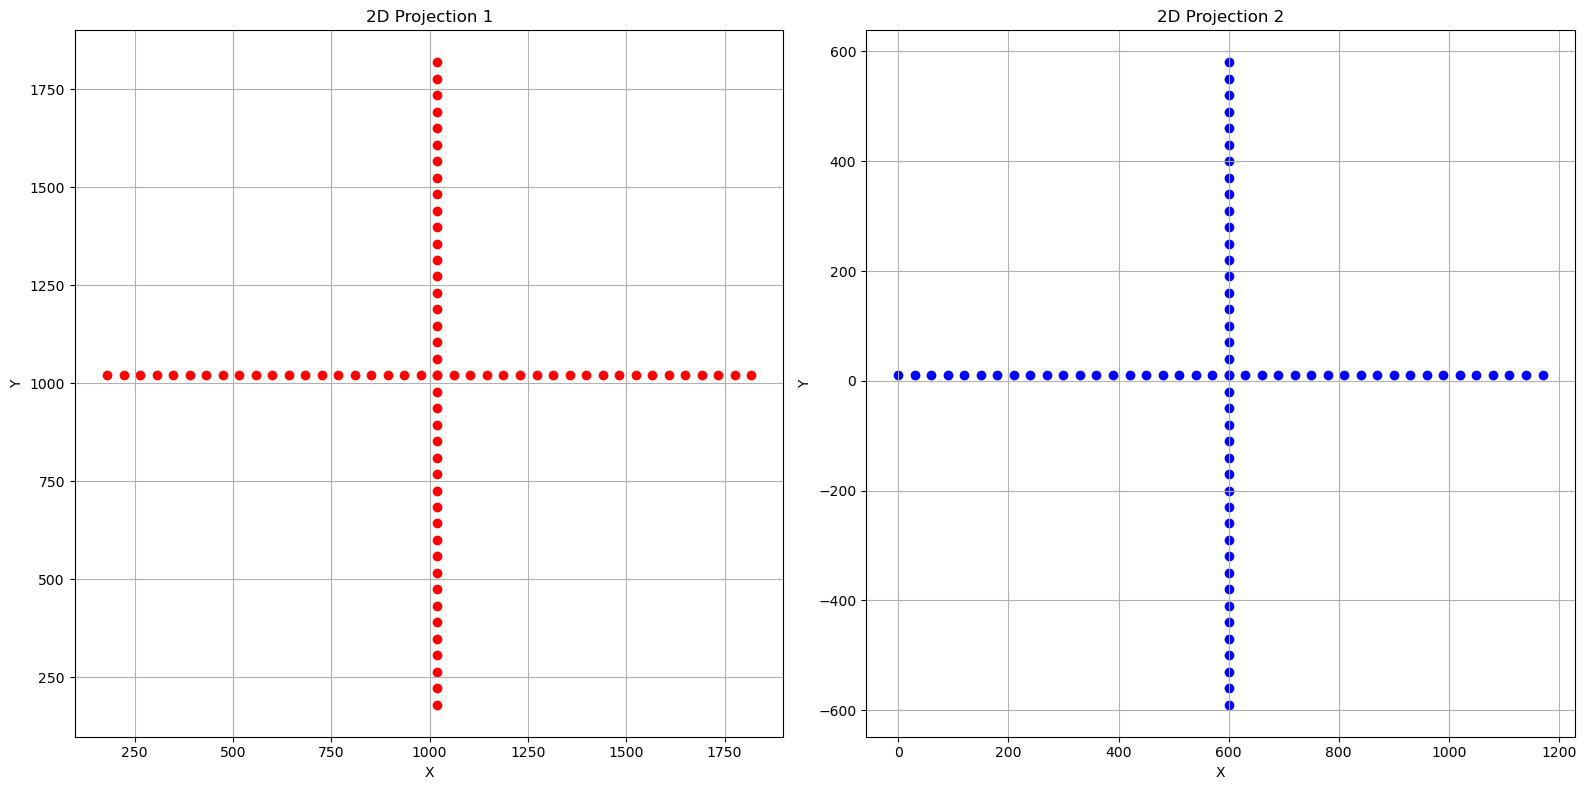

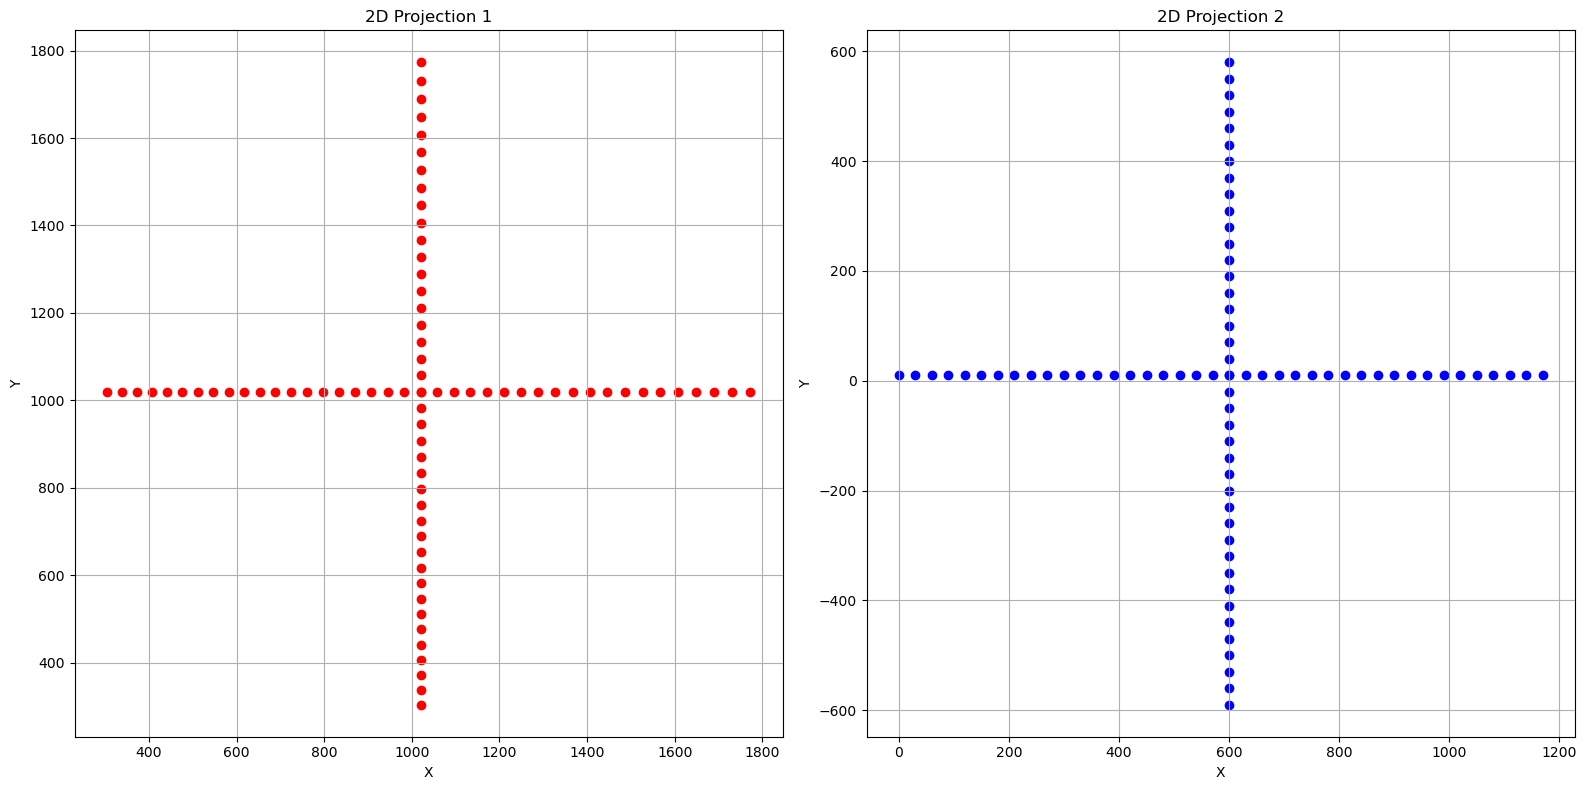

In [322]:
def plot_2d_projections(points_2d_1, points_2d_2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot the first set of points
    axes[0].scatter(points_2d_1[:, 0], points_2d_1[:, 1], color='red', marker='o')
    axes[0].set_title("2D Projection 1")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].grid(True)
    
    # Plot the second set of points
    axes[1].scatter(points_2d_2[:, 0], points_2d_2[:, 1], color='blue', marker='o')
    axes[1].set_title("2D Projection 2")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


images_Xaxis = [u_valid_0, u_valid_5] # Get X data from images (WE CANNOT USE Y IN REAL EXAMPLE)
u_init = 1020 # Set the guess of the optical center 
image_2d = [] 
pattern_2d = []

for u_valid in images_Xaxis:
    pattern_coordinates = feature_points_correspondences(np.array(u_valid),h,l) # Find world coordinates!
    u_valid = u_valid[:pattern_coordinates.shape[0]]
    print(pattern_coordinates.shape)
    print(np.array(u_valid).shape)
    #plot_2d_projection(pattern_coordinates) 

    image_2d_temp = project_feature_points_1d_to_2d(u_valid, u_init) # Make the 1D image points into a 2D with the optical center as the middle
    pattern_2d_temp = project_pattern_points(u_valid, pattern_coordinates, u_init) # Make the 1D world coordnates into 2D with the optical center projected and as the middle

    

    #plot_2d_projection(image_2d)
    #plot_2d_projection(pattern_2d)
    image_2d.append(image_2d_temp)
    pattern_2d.append(pattern_2d_temp)

print(len(image_2d))
plot_2d_projections(image_2d[0],pattern_2d[0])
plot_2d_projections(image_2d[1],pattern_2d[1])


In [323]:
for i in range(0, len(pattern_2d[0])):
    print(f"pattern: {pattern_2d[0][i]} | image: {image_2d[0][i]}")

pattern: [ 0. 10.] | image: [ 180. 1020.]
pattern: [30. 10.] | image: [ 222. 1020.]
pattern: [60. 10.] | image: [ 264. 1020.]
pattern: [90. 10.] | image: [ 306. 1020.]
pattern: [120.  10.] | image: [ 348. 1020.]
pattern: [150.  10.] | image: [ 390. 1020.]
pattern: [180.  10.] | image: [ 432. 1020.]
pattern: [210.  10.] | image: [ 474. 1020.]
pattern: [240.  10.] | image: [ 516. 1020.]
pattern: [270.  10.] | image: [ 558. 1020.]
pattern: [300.  10.] | image: [ 600. 1020.]
pattern: [330.  10.] | image: [ 642. 1020.]
pattern: [360.  10.] | image: [ 684. 1020.]
pattern: [390.  10.] | image: [ 726. 1020.]
pattern: [420.  10.] | image: [ 768. 1020.]
pattern: [450.  10.] | image: [ 810. 1020.]
pattern: [480.  10.] | image: [ 852. 1020.]
pattern: [510.  10.] | image: [ 894. 1020.]
pattern: [540.  10.] | image: [ 936. 1020.]
pattern: [570.  10.] | image: [ 978. 1020.]
pattern: [600.  10.] | image: [1020. 1020.]
pattern: [630.  10.] | image: [1062. 1020.]
pattern: [660.  10.] | image: [1104. 102

In [412]:
h1, mask  = cv2.findHomography(pattern_2d[0], image_2d[0],cv2.RANSAC,5) # Find homographyes with CV2
h2, status = cv2.findHomography(pattern_2d[1], image_2d[1],cv2.RANSAC,5)
matchesMask = mask.ravel().tolist()

print(matchesMask)
# Make a list of them
H_list = [h1, h2]
print("H:")
id=1
for h in H_list:
    #print(f"{id} : {h}")
    id=id+1


M, extrinsics = calibrate_from_homographies(H_list) # Find closed form solution !!NOT WORKING!!
#calibrate_from_homographies_LMA(H_list) # Find closed form solution WITH LMA !!NOT WORKING!!

print("Intrinsic Matrix M:")
print(M)

for idx, extrinsic in enumerate(extrinsics):
        print(f"\nExtrinsic Parameters for Homography {idx+1}:")
        print("Rotation Matrix R:")
        print(extrinsic['R'])
        print("Translation Vector t:")
        print(extrinsic['t'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
H:
1634.540588138251
Intrinsic Matrix M:
[[1.63454059e+03 0.00000000e+00 1.11220194e+03]
 [0.00000000e+00 1.63454059e+03 1.11220194e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Extrinsic Parameters for Homography 1:
Rotation Matrix R:
[[ 1.00000000e+00  9.61420046e-17 -9.16698362e-16]
 [ 5.37237206e-16  1.00000000e+00 -2.31861458e-15]
 [ 9.16698362e-16  2.31861458e-15  1.00000000e+00]]
Translation Vector t:
[-665.85852638  -75.85852638 1167.52899153]

Extrinsic Parameters for Homography 2:
Rotation Matrix R:
[[ 0.99367586  0.0063197   0.11068978]
 [ 0.00632765  0.99367502  0.11068287]
 [-0.11210819 -0.1121003   0.98735089]]
Translation Vector t:
[-668.79597496  -86.25954819 1354.11080296]


In [383]:

R, _ = cv2.Rodrigues(extrinsic['R'])
print(R)

[[-1.58609221e-01]
 [ 1.58618864e-01]
 [-1.58708631e-06]]


In [436]:
points_1 = np.hstack((pattern_2d[0], np.zeros((pattern_2d[0].shape[0], 1))))
points_2 = np.hstack((pattern_2d[1], np.zeros((pattern_2d[1].shape[0], 1))))


objPoints = [np.array(points_1, dtype='f'), np.array(points_2, dtype='f')]
imagePoints = [np.array(image_2d[0], dtype='f'), np.array(image_2d[1], dtype='f')]
#print(objPoints)
camera_matrix = np.array([[1.63454059e+03, 0.00000000e+00, 1.11220194e+03],
 [0.00000000e+00, 1.63454059e+03, 1.11220194e+03],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype=float)
width, height = 2048, 2048
flags = (cv2.CALIB_USE_INTRINSIC_GUESS |
         cv2.CALIB_FIX_PRINCIPAL_POINT |
         cv2.CALIB_ZERO_TANGENT_DIST)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imagePoints, 
                                                   (width, height),camera_matrix, 
                                                   None, flags=flags)

h,  w = image_2d[0].shape


newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,0,(w,h),1,(w,h))
print(f"New MTX = {newcameramtx}")


print(mtx)
print(tvecs)

New MTX = [[5.02084105e+02 0.00000000e+00 1.11220194e+03]
 [0.00000000e+00 5.02083318e+02 1.11220194e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[5.02084105e+02 0.00000000e+00 1.11220194e+03]
 [0.00000000e+00 5.02083318e+02 1.11220194e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
(array([[-665.85126845],
       [ -75.85090068],
       [ 358.73056894]]), array([[-672.38560421],
       [ -82.38664288],
       [ 417.69991244]]))


In [413]:
def project_points(X, intrinsic_params, extrinsic_params, distortion_params):
    """
    Projects 3D points onto the 2D image plane, applying lens distortion.
    """
    # Unpack intrinsic parameters
    fx = intrinsic_params['fx']
    fy = intrinsic_params['fy']
    u0 = intrinsic_params['u0']
    v0 = intrinsic_params['v0']

    # Unpack extrinsic parameters
    R = extrinsic_params['R']
    t = extrinsic_params['t']

    # Unpack distortion parameters
    k1 = distortion_params.get('k1', 0)
    k2 = distortion_params.get('k2', 0)

    # Transform 3D points to camera coordinates
    X_cam = R @ X.T + t[:, np.newaxis]  # Shape: (3, N)

    # Normalize to get image coordinates
    x = X_cam[0, :] / X_cam[2, :]
    y = X_cam[1, :] / X_cam[2, :]

    # Apply radial distortion
    r2 = x**2 + y**2
    radial = 1 + k1 * r2 + k2 * r2**2
    x_distorted = x * radial
    y_distorted = y * radial

    # Convert to pixel coordinates
    u = fx * x_distorted + u0
    v = fy * y_distorted + v0

    return np.vstack((u, v)).T
def reprojection_error(params, X_world, x_image, num_images):
    """
    Computes the reprojection error between observed and projected points.
    """
    # Unpack parameters
    fx, u0, k1, k2 = params[:4]
    intrinsic_params = {'fx': fx, 'fy': fx, 'u0': u0, 'v0': u0}
    distortion_params = {'k1': k1, 'k2': k2}
    errors = []
    idx = 4

    for i in range(num_images):
        # Extract rotation vector and translation vector
        r_vec = params[idx:idx+3]
        t_vec = params[idx+3:idx+6]
        idx += 6

        # Convert rotation vector to rotation matrix
        R, _ = cv2.Rodrigues(r_vec)

        extrinsic_params = {'R': R, 't': t_vec}

        # Project points
        x_projected = project_points(X_world[i], intrinsic_params, extrinsic_params, distortion_params)

        # Compute error
        error = (x_image[i] - x_projected).ravel()
        errors.append(error)

    return np.concatenate(errors)


In [414]:
pattern_3d = []
for pattern in pattern_2d:
    points_3D = np.hstack((pattern, np.zeros((pattern.shape[0], 1))))
    pattern_3d.append(points_3D)


In [415]:
from scipy.optimize import least_squares
# Prepare initial parameter vector
# Intrinsic parameters: fx, u0, k1, k2
fx_initial = M[0, 0]
u0_initial = M[0, 2]
k1_initial = 0.0  # Initial guess for radial distortion coefficient
k2_initial = 0.0

params_initial = [fx_initial, u0_initial, k1_initial, k2_initial]

# Append extrinsic parameters for each image
num_images = 2
for i in range(num_images):
    # Convert rotation matrix to rotation vector
    R = extrinsics[i]['R']
    r_vec, _ = cv2.Rodrigues(R)
    t_vec = extrinsics[i]['t']
    params_initial.extend(r_vec.flatten())
    params_initial.extend(t_vec.flatten())

params_initial = np.array(params_initial)

# Optimize
result = least_squares(
    reprojection_error,
    params_initial,
    args=(pattern_3d, image_2d, num_images),
    method='lm',
    verbose=2
)

# Extract optimized parameters
optimized_params = result.x
print(params_initial)
print(optimized_params)

`xtol` termination condition is satisfied.
Function evaluations 120, initial cost 4.8737e+03, final cost 1.0766e-02, first-order optimality 1.05e+00.
[ 1.63454059e+03  1.11220194e+03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.65858526e+02
 -7.58585264e+01  1.16752899e+03 -1.11175328e-01  1.11182710e-01
  3.99664746e-06 -6.68795975e+02 -8.62595482e+01  1.35411080e+03]
[ 2.17606294e+03  8.53650371e+02 -3.75088732e-04  2.45155973e-03
  3.02932527e-05 -3.03775908e-05  2.90508355e-08 -4.81178214e+02
  1.08821763e+02  1.55430269e+03 -1.52302989e-01  1.52311598e-01
  3.53490980e-06 -4.60426232e+02  1.29572243e+02  1.82579318e+03]


In [416]:
# Extract final intrinsic parameters
fx_opt, u0_opt, k1_opt, k2_opt = optimized_params[:4]
intrinsic_params_opt = {'fx': fx_opt, 'fy': fx_opt, 'u0': u0_opt, 'v0': u0_opt}
distortion_params_opt = {'k1': k1_opt, 'k2': k2_opt}

# Extract final extrinsic parameters for each image
extrinsic_params_opt = []
idx = 4
for i in range(num_images):
    r_vec = optimized_params[idx:idx+3]
    t_vec = optimized_params[idx+3:idx+6]
    idx += 6

    R_opt, _ = cv2.Rodrigues(r_vec)
    extrinsic_params_opt.append({'R': R_opt, 't': t_vec})

# Print optimized parameters
print("Optimized intrinsic parameters:")
print(intrinsic_params_opt)
print("Optimized distortion parameters:")
print(distortion_params_opt)

for i, extrinsic in enumerate(extrinsic_params_opt):
    print(f"Extrinsic parameters for image {i+1}:")
    print("Rotation matrix R:")
    print(extrinsic['R'])
    print("Translation vector t:")
    print(extrinsic['t'])


Optimized intrinsic parameters:
{'fx': 2176.0629364228053, 'fy': 2176.0629364228053, 'u0': 853.6503711645242, 'v0': 853.6503711645242}
Optimized distortion parameters:
{'k1': -0.0003750887319666636, 'k2': 0.0024515597332347805}
Extrinsic parameters for image 1:
Rotation matrix R:
[[ 1.00000000e+00 -2.95109535e-08 -3.03775903e-05]
 [ 2.85907175e-08  1.00000000e+00 -3.02932531e-05]
 [ 3.03775912e-05  3.02932522e-05  9.99999999e-01]]
Translation vector t:
[-481.17821371  108.82176307 1554.30268587]
Extrinsic parameters for image 2:
Rotation matrix R:
[[ 0.98844537 -0.01155749  0.15113631]
 [-0.01155047  0.98844667  0.1511283 ]
 [-0.15113684 -0.15112777  0.97689204]]
Translation vector t:
[-460.42623179  129.57224314 1825.79317963]
